In [1]:

from tensorflow.keras.applications import ResNet50
import os
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import torch
from custom_transformers import *
import tensorflow as tf
import matplotlib.pyplot as plt
from augmentation_generator_batch_size import *
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
def seed_everything(seed: int=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(51)

## Load data

In [3]:
cifar10 = tf.keras.datasets.cifar10

(X_train, Y_train), (X_test, Y_test) = cifar10.load_data()
print(f"X_train.shape: {X_train.shape} \nY_train.shape: {Y_train.shape} \nX_test.shape: {X_test.shape} \nY_test.shape: {Y_test.shape}")

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
X_train.shape: (50000, 32, 32, 3) 
Y_train.shape: (50000, 1) 
X_test.shape: (10000, 32, 32, 3) 
Y_test.shape: (10000, 1)


## Test Data Generator (with fraction 60% to visualize results)

Adding new samples

In [8]:
polygon_cutout = PolygonCutout(max_vertices=12, min_vertices=3, max_size_ratio=0.2, color=None, random_color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= polygon_cutout, augment_fraction=0.2, overwrite=False)

batch_x, batch_y = generator[0]

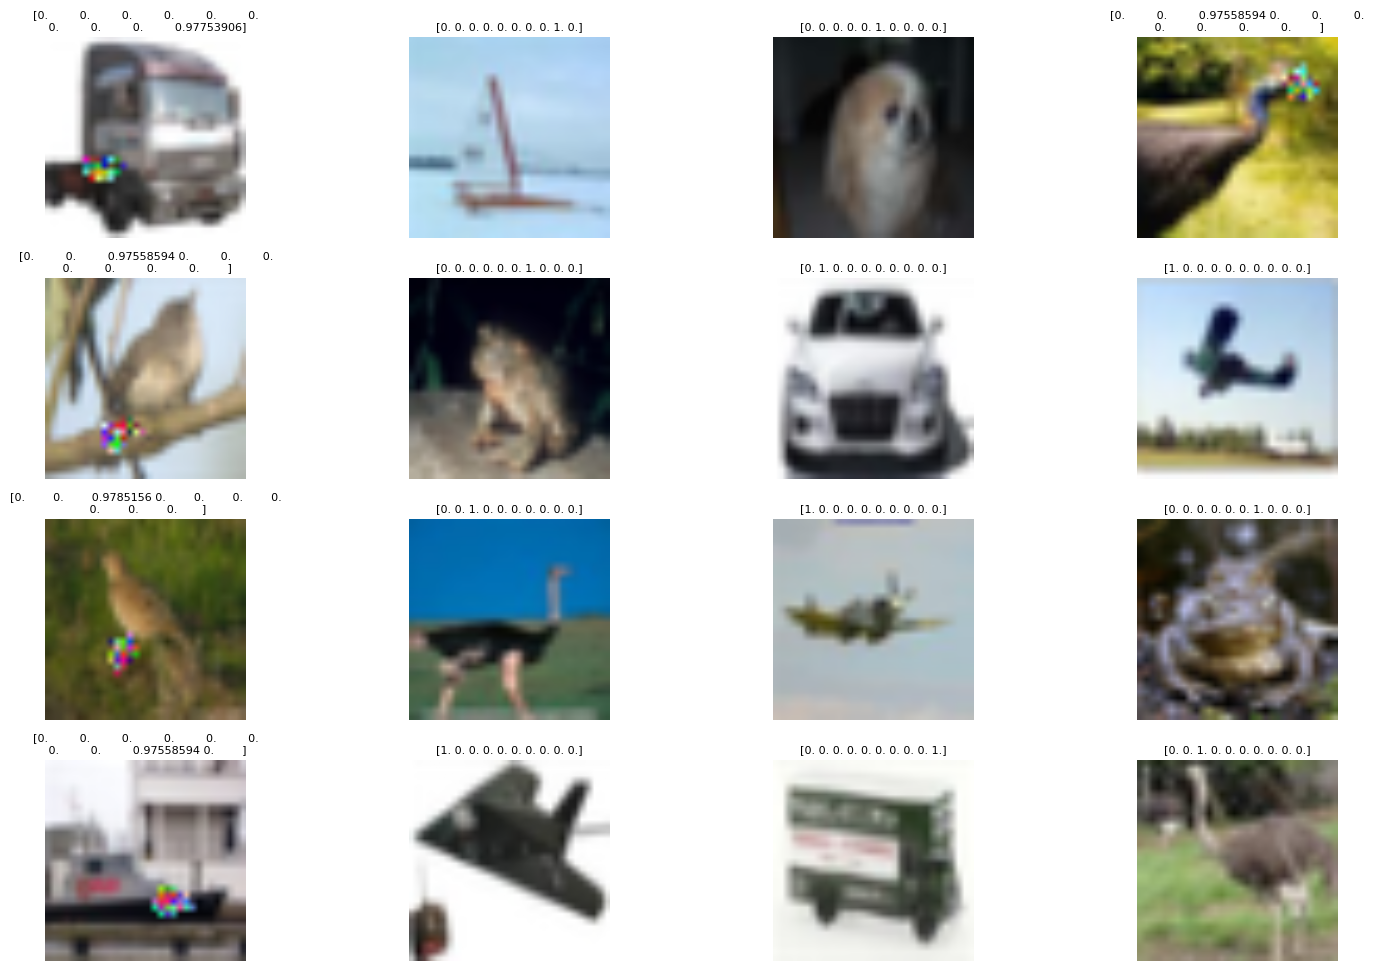

In [9]:
#function to denormalize Restnet preprocessing for visualization purposes
def denormalize_resnet(x):
    x = x.copy()
    x[..., 0] += 103.939  # Blue
    x[..., 1] += 116.779  # Green
    x[..., 2] += 123.68   # Red
    # Zamiana BGR -> RGB
    x = x[..., ::-1]
    x = np.clip(x / 255.0, 0, 1)
    return x

n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

As we can see some of the images are augmented with soft labels and added to the data and some have their original labels but with one hot encoding

With overwrite

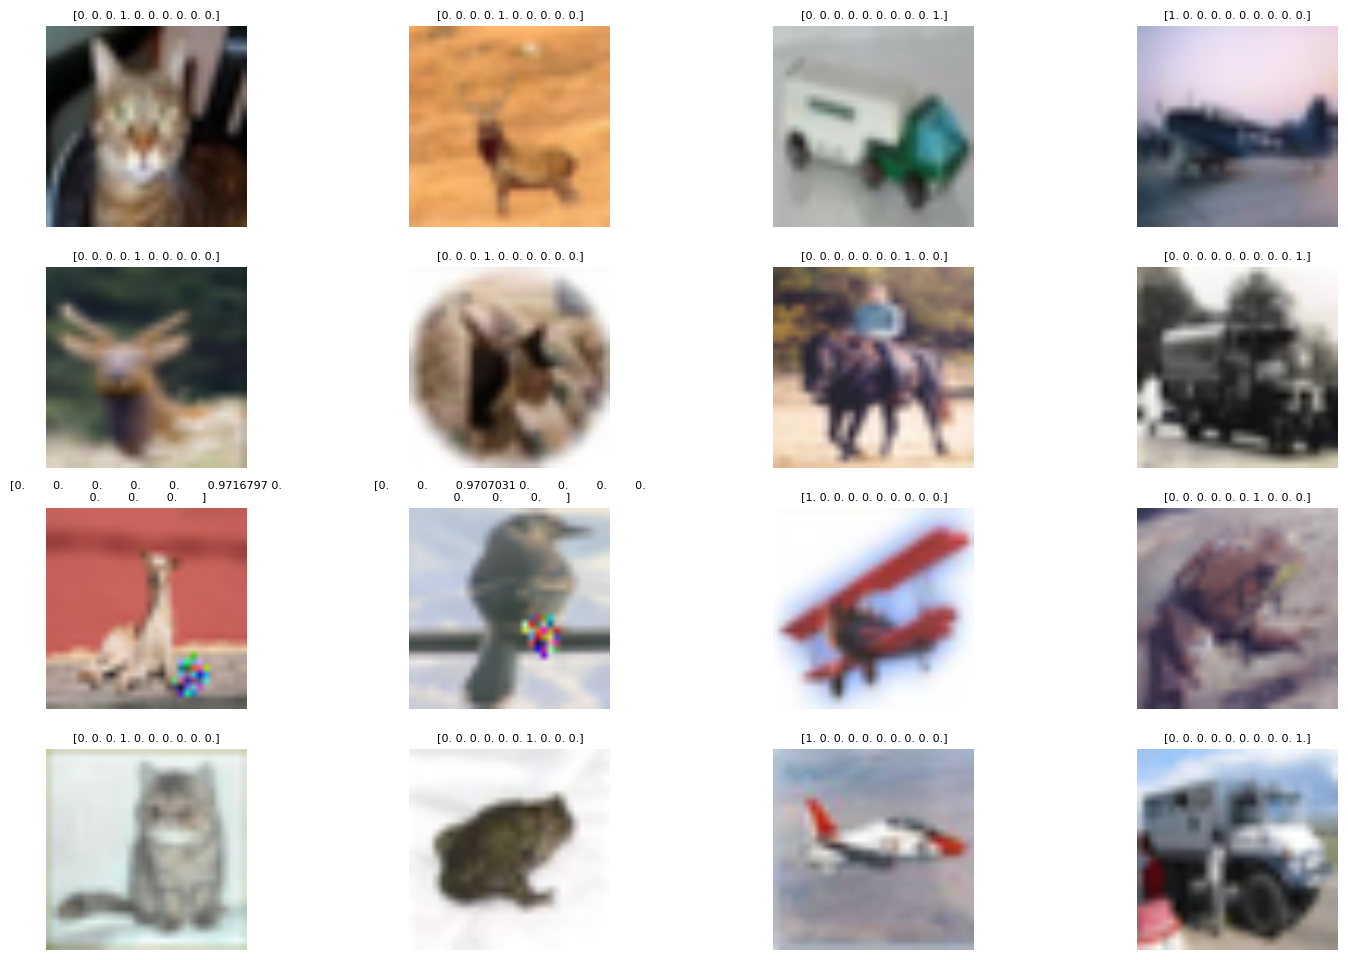

In [10]:
polygon_cutout = PolygonCutout(max_vertices=12, min_vertices=3, max_size_ratio=0.2, color=None, random_color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= polygon_cutout, augment_fraction=0.2, overwrite=True)
batch_x, batch_y = generator[0]


n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

## Restnet Training - Color Polygon

In [11]:

polygon_cutout = PolygonCutout(max_vertices=12, min_vertices=3, max_size_ratio=0.2, color=None, random_color=True)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Create generators
train_gen = AugmentedCIFAR10Generator(
    X_train,
    Y_train,
    batch_size=32,
    augmentor=polygon_cutout,
    augment_fraction=0.2,
    overwrite=False
)

test_gen = AugmentedCIFAR10Generator(
    X_test,
    Y_test,
    batch_size=32,
    shuffle=False,  # No augmentation for test set
    augmentor=None
)


model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Works with both one-hot and soft labels
    metrics=['accuracy']
)

history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 205s 102ms/step - accuracy: 0.7574 - loss: 0.7298 - val_accuracy: 0.8801 - val_loss: 0.3435
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 184s 98ms/step - accuracy: 0.8453 - loss: 0.4454 - val_accuracy: 0.8890 - val_loss: 0.3173
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 184s 98ms/step - accuracy: 0.8488 - loss: 0.4442 - val_accuracy: 0.8813 - val_loss: 0.3459
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 184s 98ms/step - accuracy: 0.8333 - loss: 0.5576 - val_accuracy: 0.8622 - val_loss: 0.5486
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 184s 98ms/step - accuracy: 0.8126 - loss: 0.9707 - val_accuracy: 0.8708 - val_loss: 0.8644


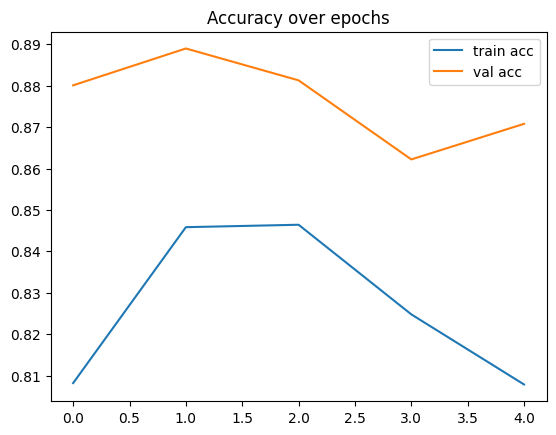

In [12]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [13]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Dokładność na zbiorze testowym: {test_acc:.2%}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 84ms/step - accuracy: 0.8711 - loss: 0.8567
Dokładność na zbiorze testowym: 87.08%


In [14]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step

<ipython-input-15-8eea66e6b0ca>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label_index = int(Y_test[image_number])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


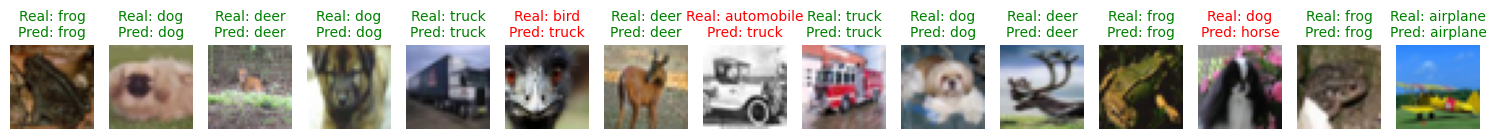

In [15]:
def label_check(image_numbers):
    fig, axes = plt.subplots(1, len(image_numbers), figsize=(15, 5))

    for i, image_number in enumerate(image_numbers):
        ax = axes[i] if len(image_numbers) > 1 else axes

        image = X_test[image_number]
        ax.imshow(image)
        ax.axis('off')

        image_resized = cv2.resize(image, (224, 224))
        image_preprocessed = preprocess_input(image_resized.astype(np.float32))
        image_input = image_preprocessed.reshape(1, 224, 224, 3)

        predicted_label_index = model.predict(image_input).argmax()
        predicted_label = labels[predicted_label_index]

        actual_label_index = int(Y_test[image_number])
        actual_label = labels[actual_label_index]

        correct = predicted_label_index == actual_label_index
        color = 'green' if correct else 'red'

        ax.set_title(f"Real: {actual_label}\nPred: {predicted_label}", fontsize=10, color=color)

    plt.tight_layout()
    plt.show()
label_check(range(30,45))

In [16]:
model.save("polygon_cutout_bigger.keras")  # lub .keras




model with smaller polygon size

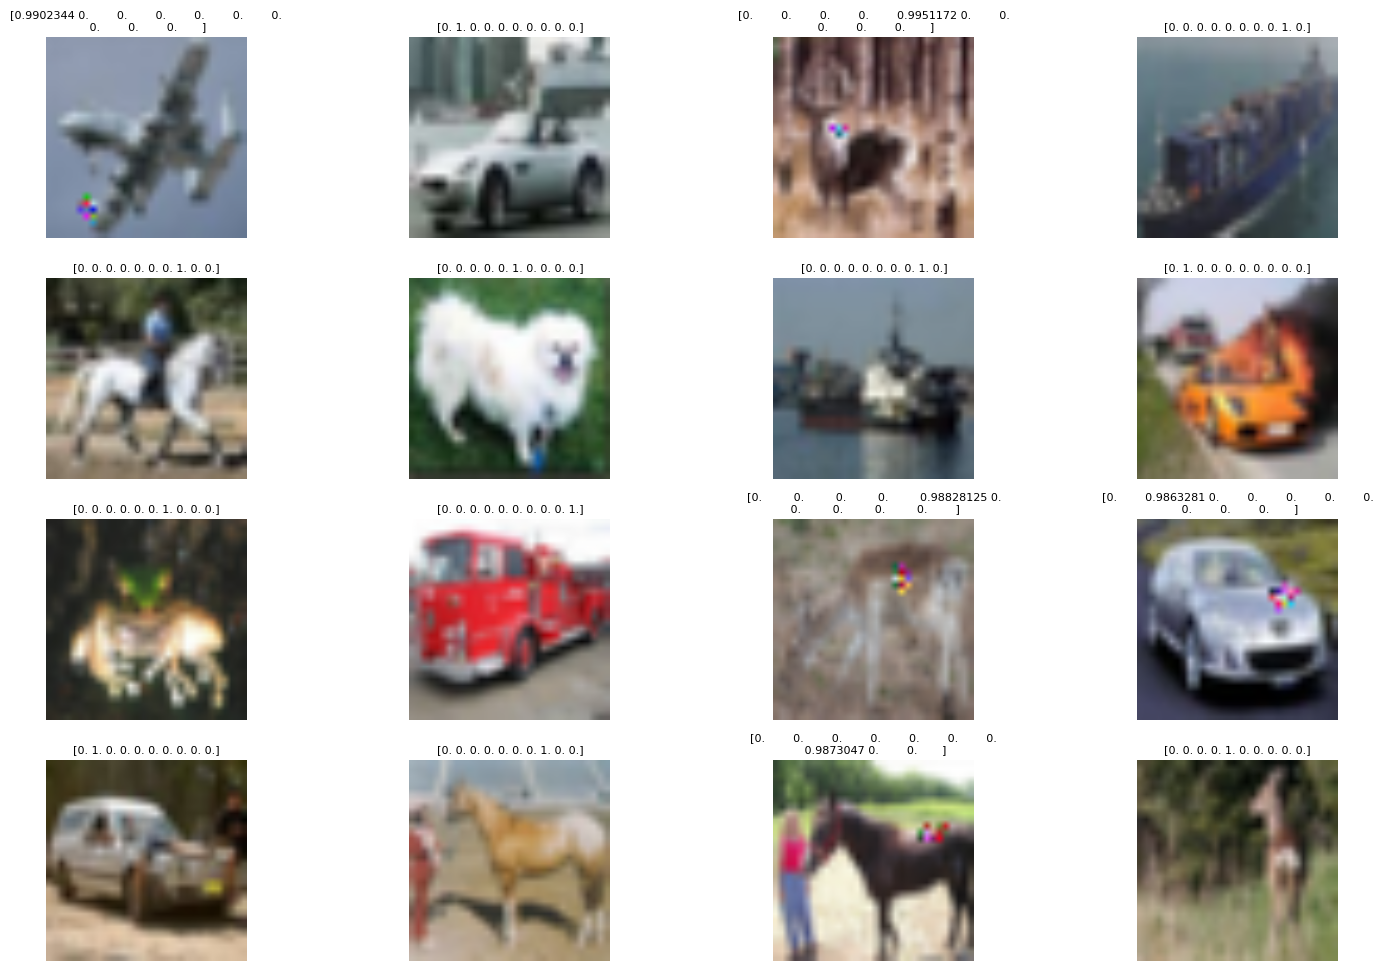

In [18]:
polygon_cutout = PolygonCutout(max_vertices=12, min_vertices=3, max_size_ratio=0.15, color=None, random_color=True)
generator = AugmentedCIFAR10Generator(X_train, Y_train, batch_size=16, shuffle=True, augmentor= polygon_cutout, augment_fraction=0.2, overwrite=True)
batch_x, batch_y = generator[0]


n = len(batch_x)
cols = 4
rows = n//cols + int(n%cols != 0)

fig, axes = plt.subplots(rows, cols, figsize=(18, 12))
if rows == 1 or cols == 1:
    axes = np.expand_dims(axes, axis=0)
for i in range(len(batch_x)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(denormalize_resnet(batch_x[i]))
    ax.set_title(batch_y[i], fontsize=8)
    ax.axis('off')

In [20]:
polygon_cutout = PolygonCutout(max_vertices=12, min_vertices=3, max_size_ratio=0.15, color=None, random_color=True)


base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(10, activation='softmax')(x)

model2 = Model(inputs=base_model.input, outputs=predictions)

# Create generators
train_gen = AugmentedCIFAR10Generator(
    X_train,
    Y_train,
    batch_size=32,
    augmentor=polygon_cutout,
    augment_fraction=0.2,
    overwrite=False
)

test_gen = AugmentedCIFAR10Generator(
    X_test,
    Y_test,
    batch_size=32,
    shuffle=False,  # No augmentation for test set
    augmentor=None
)


model2.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # Works with both one-hot and soft labels
    metrics=['accuracy']
)

history = model2.fit(
    train_gen,
    validation_data=test_gen,
    epochs=5
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 201s 102ms/step - accuracy: 0.7618 - loss: 0.7164 - val_accuracy: 0.8818 - val_loss: 0.3470
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 184s 98ms/step - accuracy: 0.8501 - loss: 0.4327 - val_accuracy: 0.8960 - val_loss: 0.3103
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 200s 106ms/step - accuracy: 0.8620 - loss: 0.4005 - val_accuracy: 0.8978 - val_loss: 0.3062
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 185s 99ms/step - accuracy: 0.8681 - loss: 0.3802 - val_accuracy: 0.8982 - val_loss: 0.3066
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 202s 99ms/step - accuracy: 0.8740 - loss: 0.3669 - val_accuracy: 0.8938 - val_loss: 0.2982


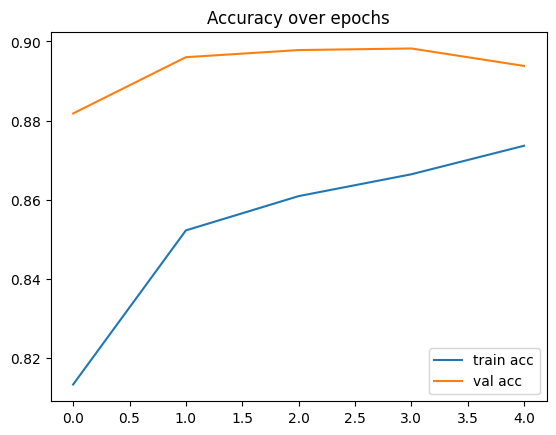

In [21]:
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy over epochs")
plt.show()

In [24]:
test_loss, test_acc = model2.evaluate(test_gen)
print(f"Dokładność na zbiorze testowym: {test_acc:.2%}")

313/313 ━━━━━━━━━━━━━━━━━━━━ 27s 86ms/step - accuracy: 0.8967 - loss: 0.2938
Dokładność na zbiorze testowym: 89.38%


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


<ipython-input-15-8eea66e6b0ca>:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_label_index = int(Y_test[image_number])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


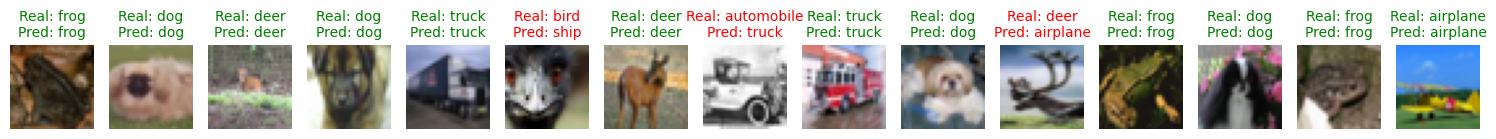

In [25]:
label_check(range(30,45))

In [26]:
model.save("polygon_cutout_smaller.keras")